In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
day = "0606"
name_notebook = day + "-sh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [9]:
n_aminoacids = len(string_list[0])

In [10]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_final_11,
    measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 5,
    # wrapper_qlayer = pw.QLayerEmpty,
)

In [11]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'block_weights': (60,), 'final_weights': (12,)}, (4,))

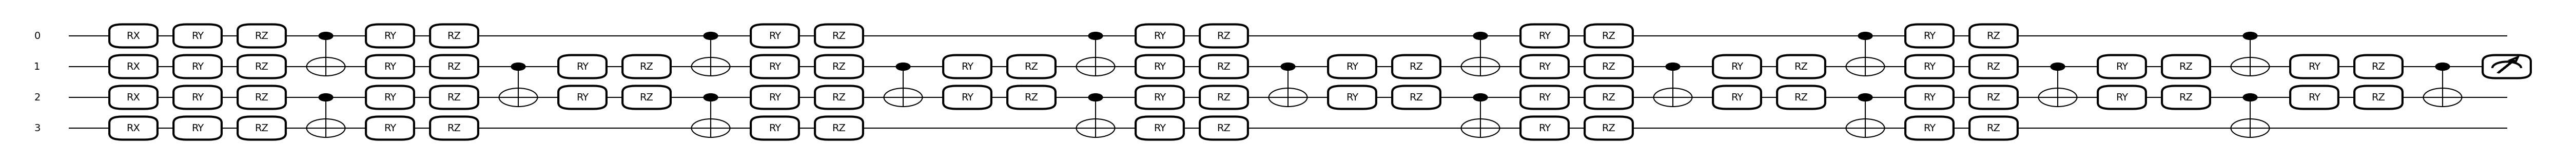

In [12]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [13]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [14]:
import torch.nn as nn
import torch
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [15]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [16]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [17]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [18]:
x = input_data[0:2]
for i, layer in enumerate(model.model):
    x = layer(x)
    print(i, x.shape, x)

0 torch.Size([2, 4, 1]) tensor([[[-1.2160],
         [-0.0591],
         [ 0.4361],
         [-1.1229]],

        [[ 1.3389],
         [ 1.6460],
         [-1.1229],
         [-1.0971]]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([2, 4]) tensor([[-1.2160, -0.0591,  0.4361, -1.1229],
        [ 1.3389,  1.6460, -1.1229, -1.0971]], grad_fn=<SqueezeBackward0>)
2 torch.Size([2, 1]) tensor([[ 0.1427],
        [-0.1544]], grad_fn=<ReshapeAliasBackward0>)
3 torch.Size([2, 1]) tensor([[-0.0144],
        [-0.1591]], grad_fn=<AddmmBackward0>)


In [19]:
for i in range(2):
    x = input_data[i]
    for i, layer in enumerate(model.model):
        x = layer(x)
        print(i, x.shape, x)

    print('')

0 torch.Size([4, 1]) tensor([[-1.2160],
        [-0.0591],
        [ 0.4361],
        [-1.1229]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([4]) tensor([-1.2160, -0.0591,  0.4361, -1.1229], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([0.1427], grad_fn=<CatBackward0>)
3 torch.Size([1]) tensor([-0.0144], grad_fn=<AddBackward0>)

0 torch.Size([4, 1]) tensor([[ 1.3389],
        [ 1.6460],
        [-1.1229],
        [-1.0971]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([4]) tensor([ 1.3389,  1.6460, -1.1229, -1.0971], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([-0.1544], grad_fn=<CatBackward0>)
3 torch.Size([1]) tensor([-0.1591], grad_fn=<AddBackward0>)



In [20]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.0144],
        [-0.1591]], grad_fn=<AddmmBackward0>)
tensor([-0.1591], grad_fn=<AddBackward0>)


In [21]:
model.keep_track_params=False

In [22]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.1},
    num_epochs = 3,                
    batch_size = 32,
)

Folder '../checkpoints/0606' created successfully.
Folder '../checkpoints/0606/plots' created successfully.
Folder '../checkpoints/0606/models' created successfully.
Folder '../checkpoints/0606/pdfs' created successfully.
Folder '../checkpoints/0606/notebooks' created successfully.
Folder '../checkpoints/0606/txts' created successfully.
Folder '../checkpoints/0606/versions' created successfully.
Folder '../checkpoints/0606/pickled_objects' created successfully.
Epoch [0/3], Loss: 1.2664, Loss validation: 1.2430
	 Validation string, 	 i: 0; 	 prediction: 0.1019, 	 target: 0.1623, 	 loss: 0.3725
	 Validation string, 	 i: 1; 	 prediction: -0.0339, 	 target: -0.0810, 	 loss: 0.5812
	 Validation string, 	 i: 2; 	 prediction: -0.0016, 	 target: -0.0440, 	 loss: 0.9637
Epoch [1/3], Loss: 0.7318, Loss validation: 0.5587, Time remaining: ~0.0h 1.0m 10s
	 Validation string, 	 i: 0; 	 prediction: 0.0977, 	 target: 0.1623, 	 loss: 0.3982
	 Validation string, 	 i: 1; 	 prediction: -0.0640, 	 target

In [23]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
        "Quantum_circuit": quantum_layer.__str__(),
    }
)

Saved in:  ../checkpoints/0606/txts/0606-sh_em_1qm_model_str_1.txt


In [24]:
# len(model.parameters)

Saved in:  ../checkpoints/0606/plots/0606-sh_em_1qm_losses_batches_1.png


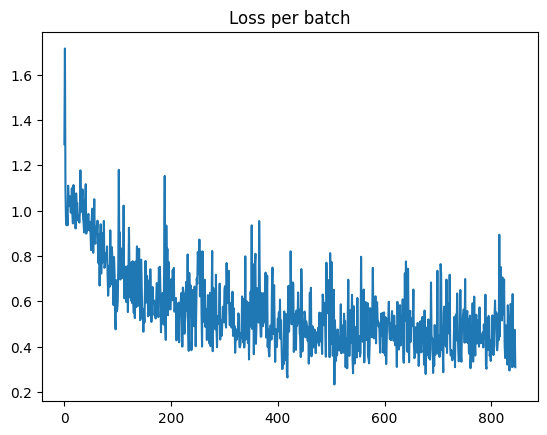

Saved in:  ../checkpoints/0606/plots/0606-sh_em_1qm_losses_epochs_1.png


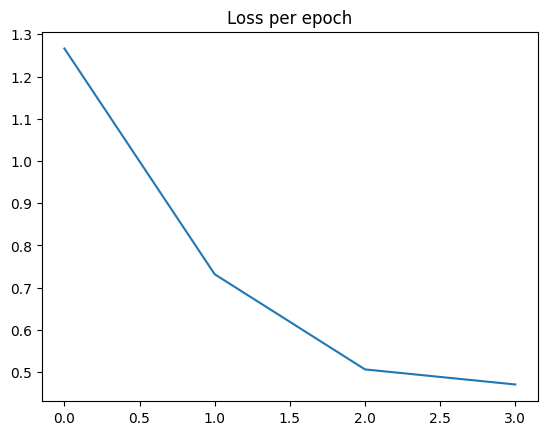

Saved in:  ../checkpoints/0606/plots/0606-sh_em_1qm_losses_epochs_validation_1.png


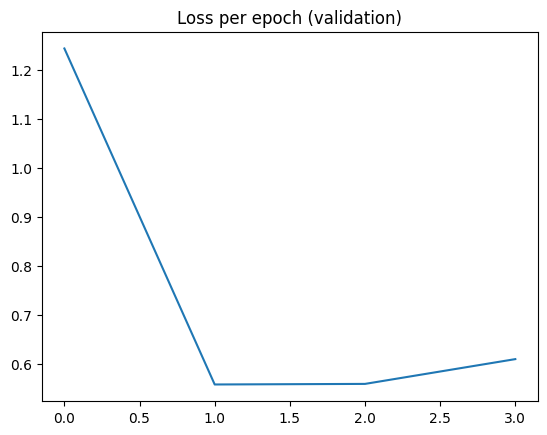

Saved in:  ../checkpoints/0606/txts/0606-sh_em_1qm_losses_batches_1.txt
Saved in:  ../checkpoints/0606/txts/0606-sh_em_1qm_losses_epochs_1.txt
Saved in:  ../checkpoints/0606/txts/0606-sh_em_1qm_losses_epochs_validation_1.txt


In [25]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True, save_txt=True)

In [26]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.


In [27]:
# model.plot_parameter(layer='7.weights', index=50)

In [28]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as ../checkpoints/0606/models/0606-sh_em_1qm_1.pth


Saved in:  ../checkpoints/0606/plots/0606-sh_em_1qm_validation_1.png


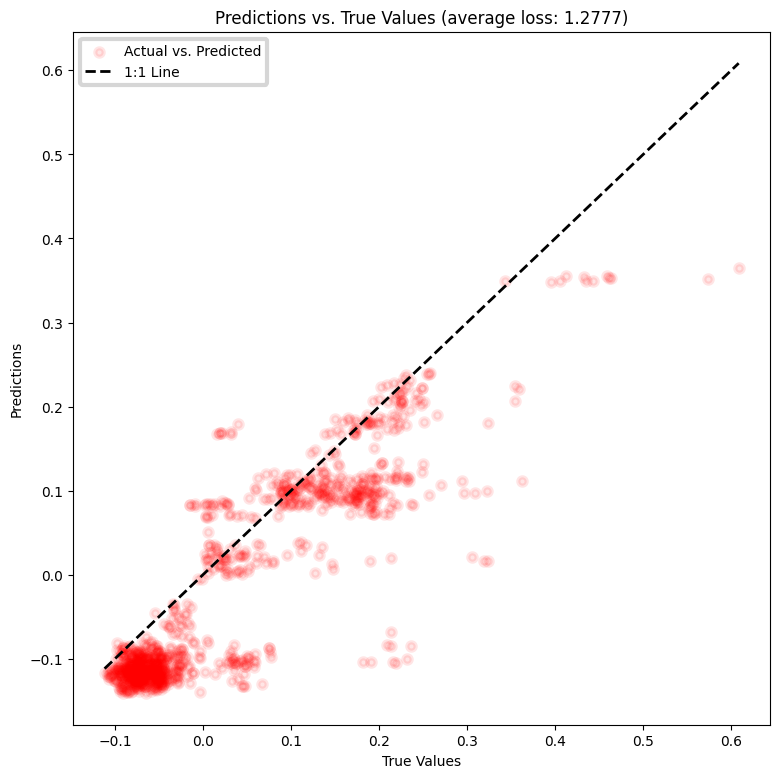

In [29]:
model.plot_validation(save=True, fig_size=(9,9))

In [30]:
# print validation and save it
model.str_validation(save=True, precision=4, percentatge=1)

Saved in:  ../checkpoints/0606/txts/0606-sh_em_1qm_validation_1.txt


In [31]:
model.model

Sequential(
  (0): Embedding(19, 1)
  (1): Reshape()
  (2): <Quantum Torch Layer: func=circuit>
  (3): Linear(in_features=1, out_features=1, bias=True)
)

In [32]:
model.dump()

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 8fd56a1c] data trained model
 13 files changed, 1041 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0829/models/0829-sh_em_1qm_8.pth
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_batches_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_epoch_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_epoch_validation_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_0.weight_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.block_weights_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.final_weights_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.bias_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.weight_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_validation_8.png
 create mode 100644 checkpoints/0829/txts/0829-sh_em_1qm_model_str_8.txt
 cr